# Difference-in-Differences

This notebook shows how to estimate a difference-in-differences using the `pyfixest` package. First we show the case of one cohort treated and use TWFE to estimate the effect. Then we show the case of multiple cohorts treated and the problems with TWFE.

For more information, see the [documentation](https://py-econometrics.github.io/pyfixest/difference-in-differences.html).

For a survey of the literature, see [Causal Panel Data](https://arxiv.org/abs/2311.15458).

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyfixest as pf

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

## 2x2 Design

The data is from the `pyfixest` package and is a panel data set with the following variables:
 - `unit`: the unit identifier
 - `year`: the time identifier
 - `treat`: a binary variable indicating whether the unit is treated
 - `Y`: the outcome variable

In [2]:
from pyfixest.utils.dgps import get_sharkfin

df_one_cohort = get_sharkfin()
df_one_cohort.head()

,unit,year,treat,Y,ever_treated
0,0,0,0,1.629307,0
1,0,1,0,0.825902,0
2,0,2,0,0.208988,0
3,0,3,0,-0.244739,0
4,0,4,0,0.804665,0


The data has the following structure:

$$
\quad \mathbf{Y}^{\mathbf{t h i n}}=\left(\begin{array}{ccc}
Y_{11} & Y_{12} & Y_{13} \\
Y_{21} & Y_{22} & Y_{23} \\
Y_{31} & Y_{32} & Y_{33} \\
Y_{41} & Y_{42} & Y_{43} \\
Y_{51} & Y_{52} & Y_{53} \\
Y_{61} & Y_{62} & Y_{63} \\
\vdots & \vdots & \vdots \\
Y_{N 1} & Y_{N 2} & Y_{N 3}
\end{array}\right), \qquad
\mathbf{W}^{\text {block }}=\left(\begin{array}{ccccccc}
0 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & 1 & \ldots & 1 & 1 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 1 & \ldots & 1 & 1
\end{array}\right)
$$

- Thin data: the number of cross-section units is large relative to the number of time periods
- Block assignment: a subset of units is treated every period after a common starting date

We can use `panelview` to visualize how many treated and control units we have in each year

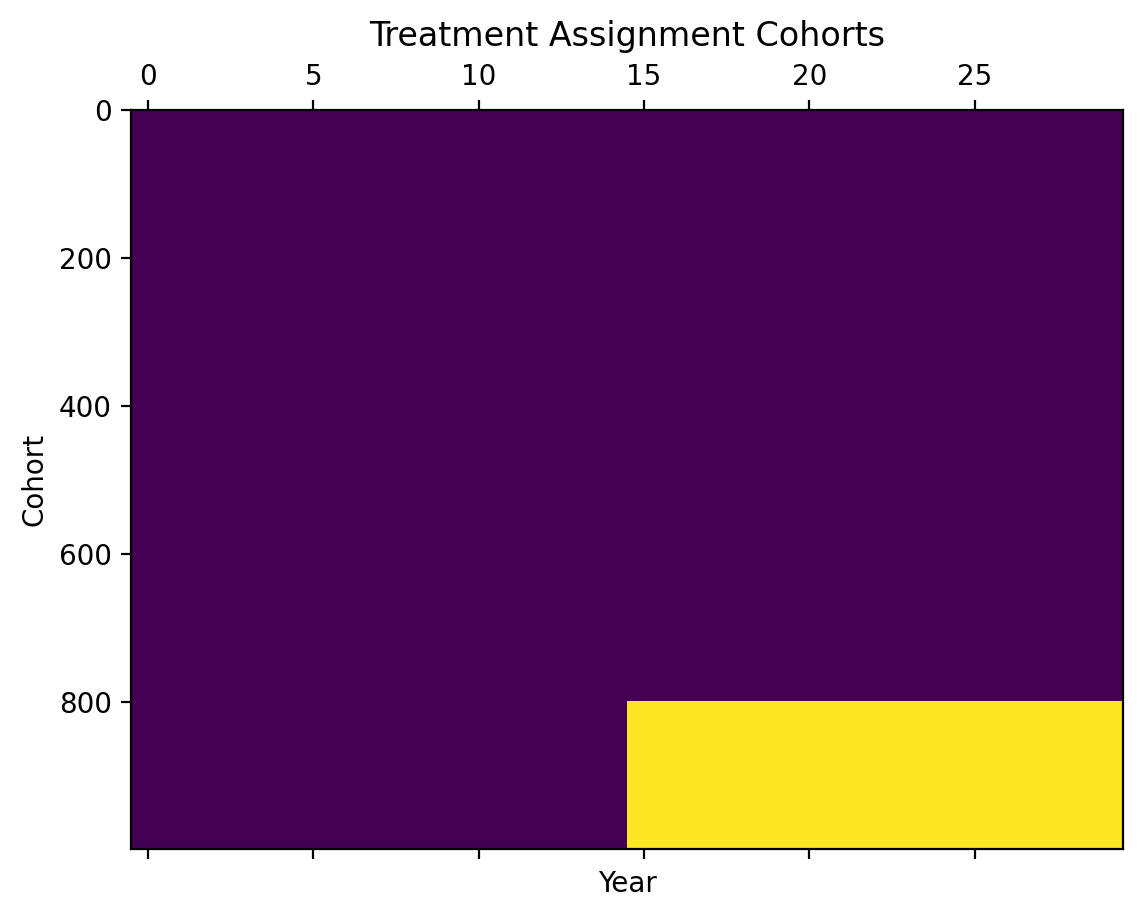

In [ ]:
pf.panelview(
    df_one_cohort,
    unit="unit",
    time="year",
    treat="treat",
    sort_by_timing=True,
    ylab="Cohort",
    xlab="Year",
    title="Treatment Assignment Cohorts",
    figsize=(0.5, 0.5),
)

plt.show()

And plot the evolution of the outcome variable for treated and control units

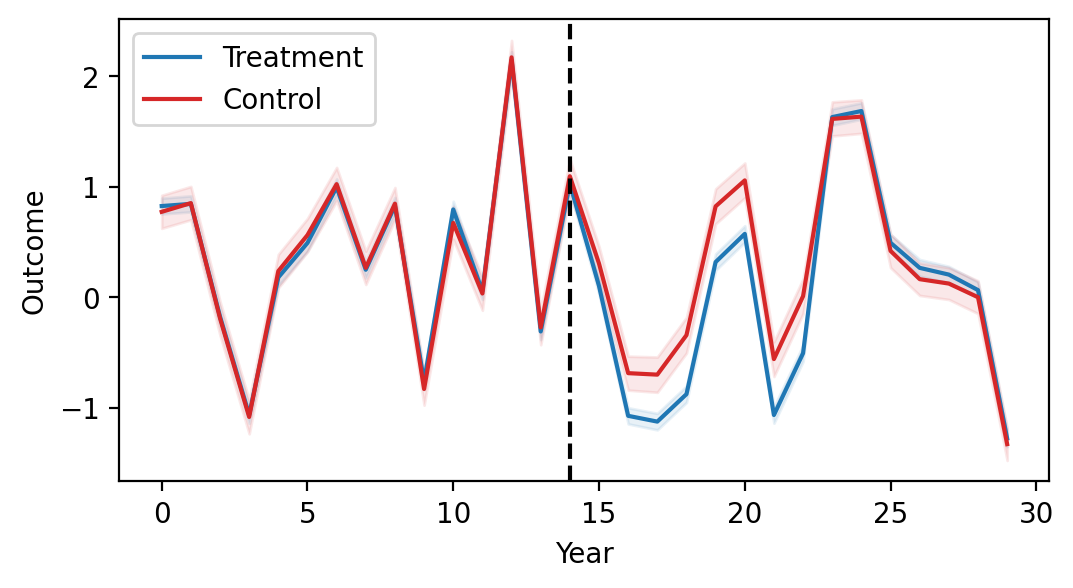

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))

# Calculate means and standard errors
means = df_one_cohort.groupby(["year", "ever_treated"])["Y"].mean().unstack()
std_errors = df_one_cohort.groupby(["year", "ever_treated"])["Y"].sem().unstack()

# Plot means
means.plot(ax=ax, color=['tab:blue', 'tab:red'])

# Add standard errors
ax.fill_between(means.index, means.iloc[:, 0] - std_errors.iloc[:, 0], means.iloc[:, 0] + std_errors.iloc[:, 0], color='tab:blue', alpha=0.1)
ax.fill_between(means.index, means.iloc[:, 1] - std_errors.iloc[:, 1], means.iloc[:, 1] + std_errors.iloc[:, 1], color='tab:red', alpha=0.1)

# Add legend, vertical line, labels, and show plot
plt.legend(loc="upper left", labels=["Treatment", "Control"])
plt.axvline(x=14, color="black", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Outcome")
plt.show()

## Two-Way Fixed Effects

**Assumption 1.** No-anticipation. This requires that potential outcomes do not depend on future treatments.

**Assumption 2.** Parallel trends. the average outcome of treated and control units would have followed the same trend in the absence of the treatment.

Assume that the the control outcome has a two-way fixed effect structure $Y_{i t}(0)=\alpha_i+\beta_t+\varepsilon_{i t}$, and the parallel trends assumption (with **constant treatment effects**) holds $Y_{i t}(1)=Y_{i t}(0)+\tau \quad \forall(i, t)$. The combination of these two assumptions leads to a model for the realized outcome,

$$
Y_{i t}=\alpha_i+\beta_t+\tau W_{i t}+\varepsilon_{i t} .
$$

We can estimate the parameters of this model by least squares:

$$
\left(\hat{\tau}^{\mathrm{TWFE}}, \hat{\alpha}, \hat{\beta}\right)=\arg \min _{\tau, \alpha, \beta} \sum_{i=1}^N \sum_{t=1}^T\left(Y_{i t}-\alpha_i-\beta_t-\tau W_{i t}\right)^2 .
$$

And we can write the estimator for the treatment effect as
$$
\hat{\tau}^{\mathrm{TWFE}} = \hat{\tau}^{\mathrm{DID}}=\left(\bar{Y}^{\mathrm{tr}, \text { post }}-\bar{Y}^{\mathrm{tr}, \mathrm{pre}}\right)-\left(\bar{Y}^{\mathrm{co}, \mathrm{post}}-\bar{Y}^{\mathrm{co}, \mathrm{pre}}\right) .
$$

The constant treatment effect assumption is not important in the setting with block assignment. Maintaining the TWFE for control outcomes but allowing unrestricted heterogeneity in the treatment effects $Y_{i t}(1)-Y_{i t}(0)$, the TWFE estimator (which then has the double difference form) continues to estimate a well-defined average causal effect, the ATT. The interpretation is more complex in settings with dynamic treatment effects, but the underlying estimand is still well-defined. 

In [5]:
fit_static_twfe = pf.feols("Y ~ treat | unit + year",
                           df_one_cohort, vcov={"CRV1": "unit"})
fit_static_twfe.summary()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


###

Estimation:  OLS
Dep. var.: Y, Fixed effects: unit+year
Inference:  CRV1
Observations:  30000

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| treat         |      0.206 |        0.052 |     3.929 |      0.000 |  0.103 |   0.308 |
---
RMSE: 0.701 R2: 0.905 R2 Within: 0.003 


Now we use an event study to obtain separate (dynamic) treatment effects for each time period.

$$
Y_{it} = \alpha_i + \beta_t + \sum_{k \neq 0} \tau_k \cdot \text{W}_{it}^{(k)} + \epsilon_{it}
$$

where $\text{W}_{it}^{(k)}$ is the treatment indicator for time period $k$.

In [6]:
fit_dynamic_twfe = pf.feols("Y ~ i(year, ever_treated, ref = 14) | unit + year",
                            df_one_cohort, vcov={"CRV1": "unit"})
fit_dynamic_twfe.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: unit+year
Inference:  CRV1
Observations:  30000

| Coefficient                                          |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| C(year, contr.treatment(base=14))[T.0]:ever_treated  |     -0.118 |        0.075 |    -1.578 |      0.115 | -0.265 |   0.029 |
| C(year, contr.treatment(base=14))[T.1]:ever_treated  |     -0.059 |        0.080 |    -0.736 |      0.462 | -0.215 |   0.098 |
| C(year, contr.treatment(base=14))[T.2]:ever_treated  |     -0.080 |        0.081 |    -0.983 |      0.326 | -0.240 |   0.080 |
| C(year, contr.treatment(base=14))[T.3]:ever_treated  |     -0.084 |        0.083 |    -1.015 |      0.311 | -0.246 |   0.078 |
| C(year, contr.treatment(base=14))[T.4]:ever_treated  |     -0.009 |        0.081 |    -0.108 |      0.914 | -0.167 |   0.150

But a figure says more than a thousand tables. So let's plot the event study.

In [54]:
from pyfixest.report.utils import rename_event_study_coefs

fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Event Study",
    figsize=[800, 300],
    yintercept=0,
    xintercept=13.5,
    joint=True,
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
)

What happens if you don't use simultaneous (joint) confidence intervals?

In [53]:
fit_dynamic_twfe.iplot(
    coord_flip=False,
    title="Event Study",
    figsize=[800, 300],
    yintercept=0,
    xintercept=13.5,
    joint="both",
    labels=rename_event_study_coefs(fit_dynamic_twfe._coefnames),
)

Simultaneous confidence bands can be constructed by using a carefully chosen critical values that accounts for the covariance between coefficients using the multiplier bootstrap. 

Note that simultaneous inference for all event study coefficients may be overly conservative, especially when the number of coefficients is large.

## Staggered Adoption

The staggered adoption setting has the following structure:

$$
\mathbf{W}^{\text {stag }}=\left(\begin{array}{ccccccc}
0 & 0 & 0 & 0 & \ldots & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & 0 & 1 \\
0 & 0 & 0 & 0 & \ldots & 1 & 1 \\
0 & 0 & 0 & 1 & \ldots & 1 & 1 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 1 & 1 & 1 & \ldots & 1 & 1
\end{array}\right) \quad \begin{gathered}
\text { (never adopter) } \\
\text { (very late adopter) } \\
\text { (late adopter) } \\
\text { (medium adopter) } \\
\vdots
\end{gathered}
$$

Let $A_i \equiv T+1-\sum_{t=1}^T W_{i t}$ be the adoption date (the first time unit $i$ is treated if a unit is ever treated), with the convention that $A_i \equiv \infty$ for units who never adopt the treatment, and recall that $N_a$ is the number of units with adoption date $A_i=a$. Define also the average treatment effect by time and adoption date,

$$
\tau_{t \mid a} \equiv \mathbb{E}\left[Y_{i t}(1)-Y_{i t}(0) \mid A_i=a\right] .
$$

The key is that these average treatment effects can vary both by time and by adoption date.

In [40]:
# Multiple cohorts
url = "https://raw.githubusercontent.com/s3alfisc/pyfixest/master/pyfixest/did/data/df_het.csv"
df_multi_cohort = pd.read_csv(url)

# How real data would look like
df_multi_cohort = df_multi_cohort[['dep_var', 'treat', 'unit', 'year', 'state']]
df_multi_cohort.sample(10)

,dep_var,treat,unit,year,state
38177,5.208523,False,1232,2006,36
4700,1.723982,False,152,2009,2
39988,11.337924,True,1290,2019,36
25386,3.722245,False,819,2018,31
14764,-0.039745,False,477,1998,5
38549,5.453876,True,1244,2006,15
44192,6.462922,True,1426,2007,26
3358,6.868181,True,109,2000,25
3684,4.010051,False,119,2016,31
27789,1.894430,False,897,2003,21


Data from 1990 to 2020:
- Group 1 is treated on 2000 (group-specific treatment effect = 2; dynamic treatment effect = 0.05*k)
- Group 2 is treated on 2010 (group-specific treatment effect = 1; dynamic treatment effect = 0.15*k)
- Group 3 is never treated

$$
Y_{it} = \sum_{k=-K}^{-2} \tau^{lead}_k D_{it}^{k} + \sum_{k=0}^{L} \tau^{lag}_k D_{it}^{k} + \alpha_i + \beta_t + e_{it}
$$

In [41]:
# Obtain first year unit was treated
treatment_first = df_multi_cohort.loc[df_multi_cohort.treat==True].drop_duplicates(subset=['unit', 'treat'], keep='first')
treatment_first = treatment_first[['unit', 'year']]
treatment_first = treatment_first.rename(columns={'year': 'group'})

# Merge first year unit was treated with the data
df_multi_cohort = df_multi_cohort.merge(treatment_first, on='unit', how='left')
df_multi_cohort['group'] = df_multi_cohort['group'].fillna(0).astype(int)

# Calculate relative year and binned relative year
bin = 8
df_multi_cohort['relative_year'] = np.where(df_multi_cohort['group'] > 0, df_multi_cohort['year'] - df_multi_cohort['group'], -np.inf)
df_multi_cohort['relative_year_binned'] = np.where(np.abs(df_multi_cohort['relative_year']) > bin, bin*np.sign(df_multi_cohort['relative_year']), 
                                        df_multi_cohort['relative_year'])
df_multi_cohort

,dep_var,treat,unit,year,state,group,relative_year,relative_year_binned
0,7.022709,False,1,1990,33,2010,-20.0,-8.0
1,7.778628,False,1,1991,33,2010,-19.0,-8.0
2,8.436377,False,1,1992,33,2010,-18.0,-8.0
3,7.191207,False,1,1993,33,2010,-17.0,-8.0
4,6.918492,False,1,1994,33,2010,-16.0,-8.0
...,...,...,...,...,...,...,...,...
46495,2.701026,False,1500,2016,2,0,-inf,-8.0
46496,1.721719,False,1500,2017,2,0,-inf,-8.0
46497,0.084874,False,1500,2018,2,0,-inf,-8.0
46498,-0.032436,False,1500,2019,2,0,-inf,-8.0


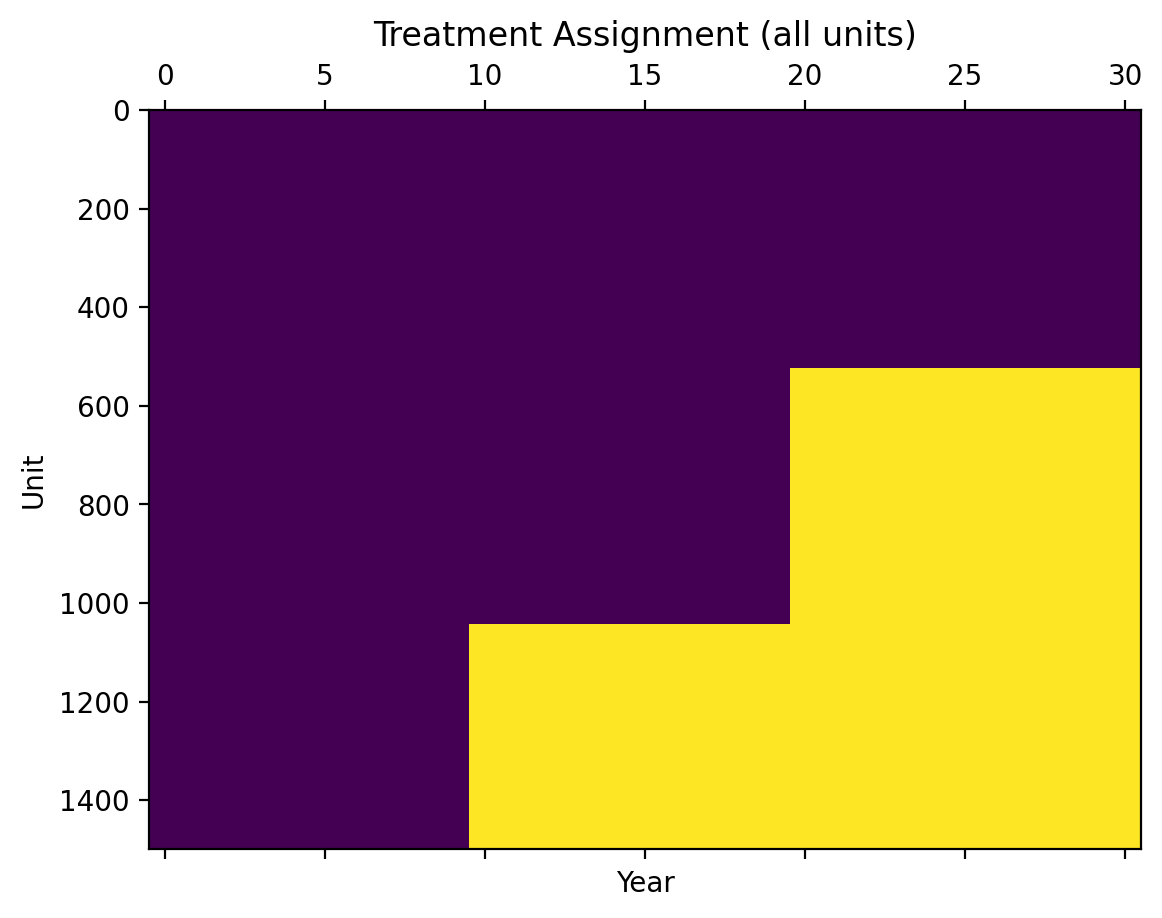

In [42]:
pf.panelview(
    df_multi_cohort,
    unit="unit",
    time="year",
    treat="treat",
    sort_by_timing=True,
    ylab="Unit",
    xlab="Year",
    title="Treatment Assignment (all units)",
    figsize=(0.5, 0.5),
)

plt.show()

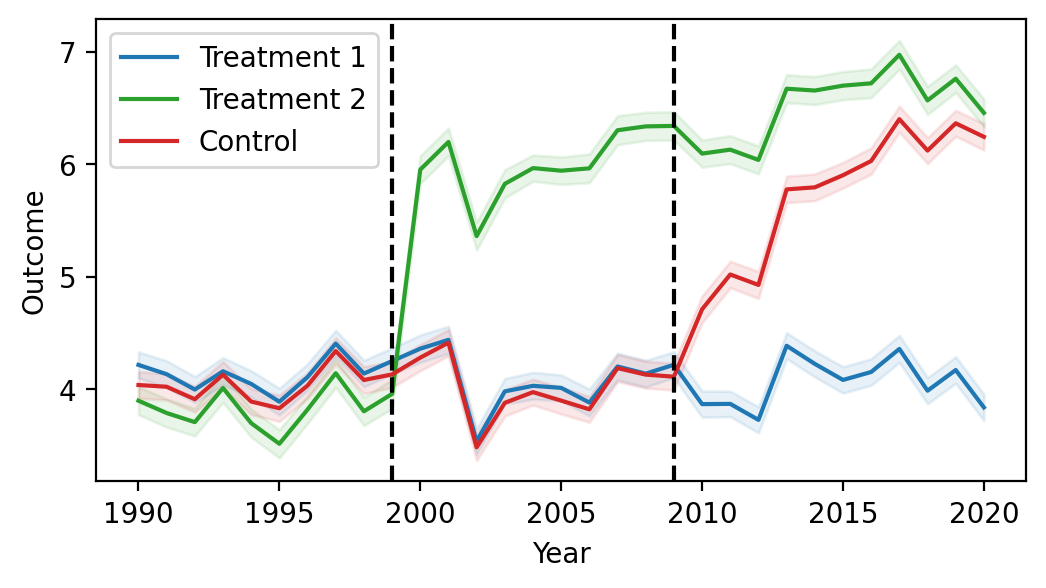

In [43]:
fig, ax = plt.subplots(figsize=(6, 3))

# Calculate means and standard errors
means = df_multi_cohort.groupby(["year", "group"])["dep_var"].mean().unstack()
std_errors = df_multi_cohort.groupby(["year", "group"])["dep_var"].sem().unstack()

# Plot means
means.plot(ax=ax, color=['tab:blue', 'tab:green', 'tab:red'])

# Add standard errors
ax.fill_between(means.index, means.iloc[:, 0] - std_errors.iloc[:, 0], means.iloc[:, 0] + std_errors.iloc[:, 0], color='tab:blue', alpha=0.1)
ax.fill_between(means.index, means.iloc[:, 1] - std_errors.iloc[:, 1], means.iloc[:, 1] + std_errors.iloc[:, 1], color='tab:green', alpha=0.1)
ax.fill_between(means.index, means.iloc[:, 2] - std_errors.iloc[:, 2], means.iloc[:, 2] + std_errors.iloc[:, 2], color='tab:red', alpha=0.1)

# Add legend, vertical line, labels, and show plot
plt.legend(loc="upper left", labels=["Treatment 1", "Treatment 2", "Control"])
plt.axvline(x=1999, color="black", linestyle="--")
plt.axvline(x=2009, color="black", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Outcome")
plt.show()

In [44]:
fit_static_twfe = pf.feols("dep_var ~ treat | unit + year",
                           df_multi_cohort, vcov={"CRV1": "state"})
fit_static_twfe.summary()

###

Estimation:  OLS
Dep. var.: dep_var, Fixed effects: unit+year
Inference:  CRV1
Observations:  46500

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| treat         |      1.983 |        0.019 |   102.556 |      0.000 |  1.943 |   2.022 |
---
RMSE: 1.003 R2: 0.877 R2 Within: 0.224 


In [51]:
fit_twfe = pf.feols("dep_var ~ i(relative_year_binned, ref=-1.0) | state + year",
                    df_multi_cohort, vcov={"CRV1": "state"})

fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=[800, 300],
    xintercept=6.5,
    yintercept=0,
    joint=True,
    labels=rename_event_study_coefs(fit_twfe._coefnames),  # rename coefficients
).show()

### What is the problem with the TWFE estimator in this setting?

Define for all time-periods $t$ and all adoption dates $a$ the average outcome in period $t$ for units with adoption date $a$ as $\bar{Y}_{t \mid a} \equiv \frac{1}{N_a} \sum_{i: A_i=a} Y_{i, t}$. Then define the following double difference that is the building block for the TWFE estimator:

$$
\hat{\tau}_{t, t^{\prime}}^{a, a^{\prime}} \equiv\left(\bar{Y}_{t \mid a}-\bar{Y}_{t^{\prime} \mid a}\right)-\left(\bar{Y}_{t \mid a^{\prime}}-\bar{Y}_{t^{\prime} \mid a^{\prime}}\right)
$$

The interpretation of this double difference plays a key role in the interpretation of the TWFE estimator $\hat{\tau}$. The group with adoption date $a$ changes treatment status between periods $t^{\prime}$ and $t$, so the difference $\bar{Y}_{t \mid a}-\bar{Y}_{t^{\prime} \mid a}$ reflects a change in treatment but this treatment effect is contaminated by the time trend in the control outcome under the TWFE structure:

$$
\mathbb{E}\left[\bar{Y}_{t \mid a}-\bar{Y}_{t^{\prime} \mid a^{\prime}}\right]=\beta_t-\beta_{t^{\prime}}+\tau_{t \mid a}
$$

For the group with an adoption date $a^{\prime}$, the difference $\bar{Y}_{t \mid a^{\prime}}-\bar{Y}_{t^{\prime} \mid a^{\prime}}$ does not capture a change in treatment status. If $t<a^{\prime}$, it is a difference in average control outcomes, and $\hat{\tau}_{t, t^{\prime}}^{a, a^{\prime}}$ is a standard DID estimand, which under the TWFE model for the control outcomes has an interpretation as an average treatment effect ("clean" comparison).

However, if $a^{\prime}<t^{\prime}$, the difference $\bar{Y}_{t \mid a^{\prime}}-\bar{Y}_{t^{\prime} \mid a^{\prime}}$ is a difference in average outcomes under the treatment. In the presence of treatment effect heterogeneity, and in the absence of a TWFE model for the outcomes under treatment, its expectation can be written as

$$
\mathbb{E}\left[\bar{Y}_{t \mid a^{\prime}}-\bar{Y}_{t^{\prime} \mid a^{\prime}}\right]=\beta_t-\beta_{t^{\prime}}+\left(\tau_{t \mid a^{\prime}}-\tau_{t^{\prime} \mid a^{\prime}}\right) .
$$


Hence, in the case with $a^{\prime}<t^{\prime}$, the previous double difference has expectation

$$
\mathbb{E}\left[\hat{\tau}_{t, t^{\prime}}^{a, a^{\prime}}\right]=\tau_{t \mid a}-\left(\tau_{t \mid a^{\prime}}-\tau_{t^{\prime} \mid a^{\prime}}\right) .
$$


This is a weighted average of treatment effects, with the weights adding up to one but with some of the weights negative. This is sometimes referred to as a "forbidden" comparison. If the treatment effects are all identical, this does not, in fact, create a concern. However, if there is reason to believe there is substantial heterogeneity, as is likely in practice, researchers may be reluctant to report weighted averages with negative weights. Note that the concern with the comparisons $\hat{\tau}_{t, t^{\prime}}^{a, a^{\prime}}$ when $a^{\prime}<t^{\prime}$ but not when $a^{\prime}>t$ fundamentally treats the treated state and the control state asymmetrically: the parallel trends assumption is maintained for the control outcomes, but not for the treated outcomes.

In [56]:
fit_twfe_2000 = pf.feols("dep_var ~ i(relative_year_binned, ref=-1.0) | state + year",
                         df_multi_cohort[df_multi_cohort['group'].isin([0, 2000])], vcov={"CRV1": "state"})
fit_twfe_2010 = pf.feols("dep_var ~ i(relative_year_binned, ref=-1.0) | state + year",
                         df_multi_cohort[df_multi_cohort['group'].isin([0, 2010])], vcov={"CRV1": "state"})

pf.report.iplot([fit_twfe_2000, fit_twfe_2010], 
                   coord_flip=False, xintercept=6.5, yintercept=0, figsize=(800, 300),
                   labels=rename_event_study_coefs(fit_twfe_2000._coefnames),
                   title="2000 vs 2010 treated")

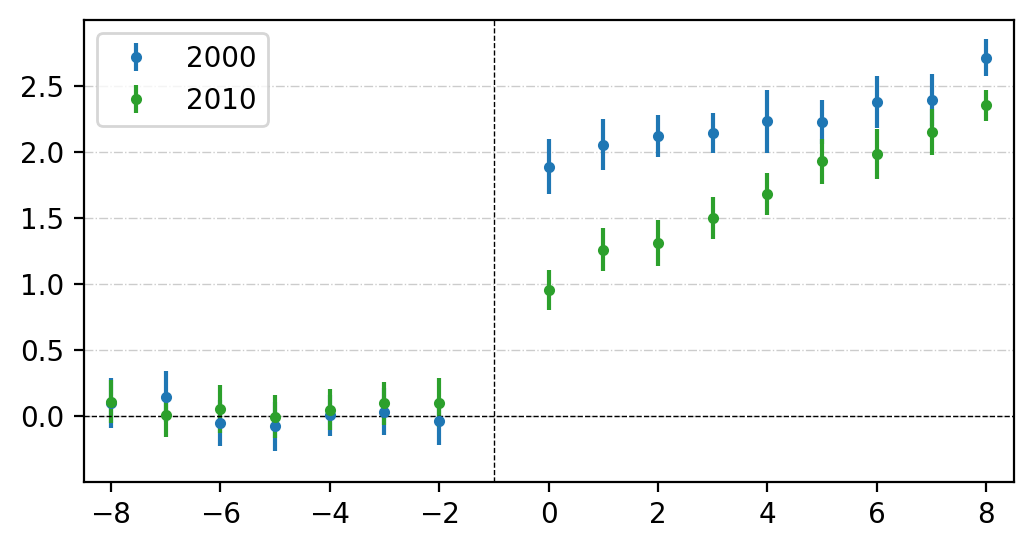

In [60]:
fig, ax = plt.subplots(figsize=(6, 3))
relative_year = np.unique(df_multi_cohort['relative_year_binned'])
relative_year = np.delete(relative_year, np.where(relative_year == -1))
ax.errorbar(relative_year, fit_twfe_2000.coef(), yerr=1.96*fit_twfe_2000.se(), fmt='.', label='2000', color='tab:blue')
ax.errorbar(relative_year, fit_twfe_2010.coef(), yerr=1.96*fit_twfe_2010.se(), fmt='.', label='2010', color='tab:green')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axvline(-1, color='black', linewidth=0.5, linestyle='--')
ax.grid(axis='y', color='black', linestyle ='-.', linewidth=0.5, alpha=0.2)
ax.set_xticks(np.arange(-8, 9, 2))
ax.set_yticks(np.arange(0, 3, 0.5))
ax.set_xlim(-8.5, 8.5)
ax.set_ylim(-0.5, 3)
plt.legend()
plt.show()